# **Text Mining and Analysis with Twitter Data**

**Joshua Peterson**
***

## **Set Up Environment**

In [3]:
# Utilities
import os
import pandas as pd
import numpy as np

# Ignore future warnings
import warnings
warnings.filterwarnings('ignore')

Mount Google Drive and set working directory.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/DSBA Research Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/19gmbQNBnP5zBu_ZfjIKfb98YxZIGkrp8/Machine Learning Project


## **Load Dataset**

In [5]:
# load tweet data from working directory
tweetdf = pd.read_csv('data/final_twitter_data.csv')
tweetdf.head()

,id,date,tweet,username,lang,replyCount,likeCount,retweetCount,tweet_class
0,1.265080e+18,2020-05-26 00:56:04+00:00,"Ian Haydon, who is participating in a vaccine ...",AC360,en,22,193,63,fake news
1,1.252420e+18,2020-04-21 02:16:11+00:00,Gachibowli Sports Tower turns Covid hospital\n...,BRSparty,en,11,409,46,fake news
2,1.253760e+18,2020-04-24 19:04:33+00:00,"Protesters at state Capitol are chanting ""Wher...",sbauerAP,en,21,567,192,fake news
3,1.237780e+18,2020-03-11 16:26:53+00:00,"🚨 BREAKING 🚨\n\n""We have therefore made the as...",WHO,en,1972,51420,50128,ambiguous
4,1.270080e+18,2020-06-08 19:53:19+00:00,1/2\n\n@WHO recently published a summary of tr...,mvankerkhove,en,100,606,283,fake news


In [6]:
# convert tweet class
tweetdf['tweet_class'] = tweetdf['tweet_class'].replace({'fake news': 'misinformation', 'true news': 'informational'})

In [7]:
# keep only relevent columns
tweetdf = tweetdf[['tweet', 'tweet_class']]
tweetdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17679 entries, 0 to 17678
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet        17679 non-null  object
 1   tweet_class  16881 non-null  object
dtypes: object(2)
memory usage: 276.4+ KB


In [8]:
# drop tweets without a label/class
tweetdf = tweetdf.dropna()
tweetdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16881 entries, 0 to 17678
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet        16881 non-null  object
 1   tweet_class  16881 non-null  object
dtypes: object(2)
memory usage: 395.6+ KB


What classes are present in the dataset?

In [9]:
tweetdf.tweet_class.value_counts()

tweet_class
informational     9004
misinformation    7395
political          378
ambiguous          104
Name: count, dtype: int64

The "political" and "ambiguous" classes are underrepresented and not relevent to the goal of the project. Therefore, those classes will be removed.

In [10]:
# drop the political and ambiguous classes as they are not well represented in the tweetdf dataset
dropindex = tweetdf[tweetdf['tweet_class'].isin(['political', 'ambiguous'])].index
tweetdf = tweetdf.drop(dropindex)
tweetdf.tweet_class.value_counts()

tweet_class
informational     9004
misinformation    7395
Name: count, dtype: int64

## **Text Preprocessing**

Preview of preprocessed tweets so we can start to understand what the contents of the tweets look like.

In [11]:
# preview sample of raw tweets
with pd.option_context('display.max_colwidth', 1):
    display(tweetdf['tweet'][0:5])

0    Ian Haydon, who is participating in a vaccine trial for coronavirus, says he feels “totally normal” after taking both doses of the vaccine but that his initial side effects from the highest dose included fever and nausea. https://t.co/q6kNQxa8xF                                                 
1    Gachibowli Sports Tower turns Covid hospital\n\nThe 14-storyed Sports Tower at the Gachibowli Stadium was left unused for more than a decade. Having been constructed in 2007 for the World Military Games....https://t.co/7UBjVQmrql\n@TelanganaToday\n#TelanganaFightsCorona https://t.co/hSQJ1Vx6Dw
2    Protesters at state Capitol are chanting "Where's our flag?" and pointing to the Capitol, saying it's a "disgrace" there is no flag\n\nThe American flag flies on the other side of the building from where they are rallying                                                                         
4    1/2\n\n@WHO recently published a summary of transmission of #COVID19, incl. symptomatic, pre-sy

The following is a function to clean tweet text. Regular expressions are used to identify patterns to be removed when cleaning tweet text.
<br>For more info on regular expression operations, see the following link:

https://docs.python.org/3/library/re.html

In [12]:
import re

def clean_text(text):
    pat1 = r'@[^ ]+' # [^ ]+
    pat2 = r'https?://[A-Za-z0-9./]+'
    pat3 = r'\'s'
    pat4 = r'\#\w+'
    pat5 = r'&amp '
    pat6 = r'[^A-Za-z\s]'
    pat7 = r'\n'
    combined_pat = r'|'.join((pat1, pat2, pat3, pat4, pat5, pat6, pat7)) # combines created regex patterns set above
    text = re.sub(combined_pat, ' ', text) # removes those regex patterns from text passed through the function
    text = re.sub(' +', ' ', text) # removes unwanted whitespace within cleaned tweet
    return text.strip() # returns the text and strips leading and trailing whitespace

Now the tweets are cleaned using the defined `clean_text` function.

In [13]:
# apply/map the 'clean_text' function to the 'tweet' column to clean the tweet text data
tweetdf['cleaned_tweet'] = tweetdf['tweet'].apply(clean_text)

with pd.option_context('display.max_colwidth', 1):
    display(tweetdf['cleaned_tweet'][0:5])

0    Ian Haydon who is participating in a vaccine trial for coronavirus says he feels totally normal after taking both doses of the vaccine but that his initial side effects from the highest dose included fever and nausea                                                       
1    Gachibowli Sports Tower turns Covid hospital The storyed Sports Tower at the Gachibowli Stadium was left unused for more than a decade Having been constructed in for the World Military Games                                                                                 
2    Protesters at state Capitol are chanting Where our flag and pointing to the Capitol saying it a disgrace there is no flag The American flag flies on the other side of the building from where they are rallying                                                               
4    recently published a summary of transmission of incl symptomatic pre symptomatic and asymptomatic transmission See page of In this summary we state Comprehensive st

Next, we will make the tweets all lowercase, remove stop words, apply lemmatization, and apply stemming.

**Lemmatization:** caring, cared, cares ➡ care

**Stemming:** eating, eats and eaten ➡ eat


In [19]:
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords

nltk.download('stopwords') # download the english stopwords dictionary
nltk.download('wordnet') # download the wordnet dictionary for lemmatization

stop = set(stopwords.words('english')) # initiate the list of stop words to be removed
new_stop = ['via'] # identify any additional stop words to be considered
all_stop = stop.union(new_stop) # add those new stopwords to the already defined list of stop words

stemmer = SnowballStemmer('english') # initiate the stemmer to be used
lemma = WordNetLemmatizer() # initiate the lemmatizer to be applied to the tweet text

# now we will process the tweet text
def process_text(data, text):
    data[text] = data[text].str.lower() # make the tweets all lowercase
    data[text] = data[text].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stop)])) # remove the set of stop words from the tweet data
    data[text] = data[text].apply(lambda x: ''.join([lemma.lemmatize(y) for y in x])) # apply lemmatizer to tweet text
    data['processed_tweet'] = data[text].apply(lambda x: ''.join([stemmer.stem(y) for y in x])) # apply stemmer to tweet text

process_text(tweetdf, 'cleaned_tweet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


What do the tweets look like now?



In [20]:
with pd.option_context('display.max_colwidth', 1):
    display(tweetdf['processed_tweet'][0:5])

0    ian haydon participating vaccine trial coronavirus says feels totally normal taking doses vaccine initial side effects highest dose included fever nausea                                                        
1    gachibowli sports tower turns covid hospital storyed sports tower gachibowli stadium left unused decade constructed world military games                                                                         
2    protesters state capitol chanting flag pointing capitol saying disgrace flag american flag flies side building rallying                                                                                          
4    recently published summary transmission incl symptomatic pre symptomatic asymptomatic transmission see page summary state comprehensive studies                                                                  
5    transmission asymptomatic individuals difficult conduct available evidence contact tracing reported member states suggests asymptomatic

**Term Frequencies**

What are the most frequent unigrams across all the tweets?

In [21]:
from collections import Counter
from itertools import chain

counter = Counter(chain.from_iterable(map(str.split, tweetdf.processed_tweet.to_list())))

counts = pd.Series(counter).sort_values(ascending=False)

counts[:20]

coronavirus    7117
covid          6303
vaccine        1419
new            1349
virus          1207
people         1195
health         1108
shows          1021
study          1006
drug            918
flu             828
outbreak        786
patients        780
symptoms        729
amp             717
research        709
us              696
trial           677
scientists      661
bioweapon       660
dtype: int64

What are the most frequent bigrams across all the tweets?

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

bivectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word') # # initiate vectorizer to be used on tweet text for bigrams
bigram_vectorized = bivectorizer.fit_transform(tweetdf["processed_tweet"]) # fit and transform the processed tweet data using the bigram vectorizer

frequencies = sum(bigram_vectorized).toarray()[0] # calculate the frequecies of the bigrams

counts = pd.Series(frequencies, index=bivectorizer.get_feature_names_out()).sort_values(ascending=False)

counts[:20]

covid vaccine           764
new coronavirus         498
positive coronavirus    470
vaccine candidate       426
coronavirus outbreak    422
shows promise           403
candidate shows         397
stable hours            373
hours surfaces          365
coronavirus stable      347
immune system           347
study finds             345
early stages            339
block early             339
significantly block     339
human tissues           338
engineered human        338
trial drug              337
bill gates              333
drug significantly      333
dtype: int64

## **Mining and Analysis of Tweets**

In [23]:
import seaborn as sns

# set theme for future seaborn plots
sns.set_theme()
sns.set_style("ticks")

# color palette dictionary to be used for future plots
pal = {"misinformation": "#A49665",
       "ambiguous": "#802F2D",
       "informational": "#005035",
       "political": "#007377"}

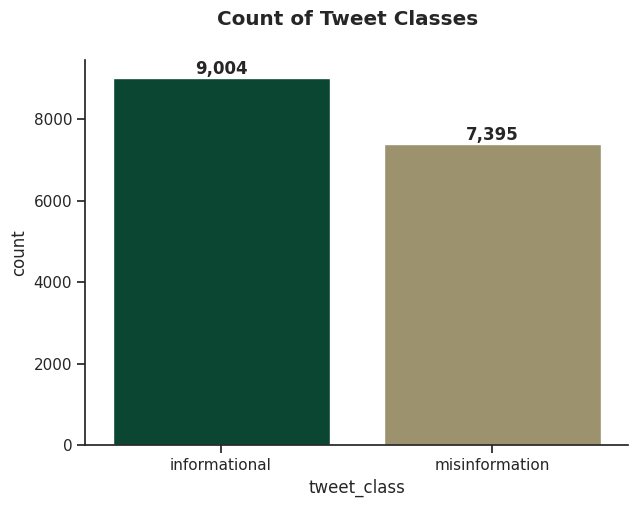

In [24]:
import matplotlib.pyplot as plt

# plotting the distribution of tweet classes.
fig, ax = plt.subplots(1, figsize=(7,5)) # set number of plots and the size of figure

p = sns.countplot(x=tweetdf['tweet_class'], palette=pal, order=tweetdf['tweet_class'].value_counts().index) # create countplot of 'tweet_class' column values
pcount = p.containers[0] # get count of classes to be shown on plot
p.bar_label(pcount, labels=[f'{x:,.0f}' for x in pcount.datavalues], fontsize='12', fontweight='bold') # add count labels to countplot
fig.suptitle("Count of Tweet Classes", fontweight='bold')

sns.despine()
plt.show()

### Word Clouds

In [25]:
truenewsdf = tweetdf.loc[(tweetdf['tweet_class'] == "informational")] # create dataset of only tweets labeled as 'true news'
fakenewsdf = tweetdf.loc[(tweetdf['tweet_class'] == "misinformation")] # create dataset of only tweets labeled as 'fake news'

Creating a word cloud using only those tweets identified as informational.

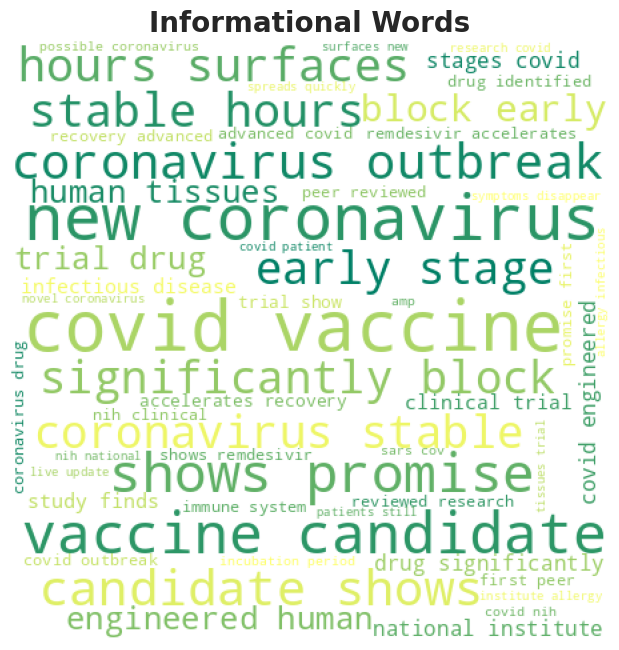

In [26]:
from wordcloud import WordCloud

text = ' '.join(list(truenewsdf['processed_tweet'])) # get list of all words in the truenewsdf dataset

wordcloud = WordCloud(width=450, height=450, background_color='white', min_font_size=8, colormap='summer').generate(text) # create wordcloud using words from tweets labeled as 'true news'

plt.figure(figsize=(6,6), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Informational Words', size='20', fontweight='bold')

plt.show()

Creating a word cloud using only those tweets identified as misinformation.

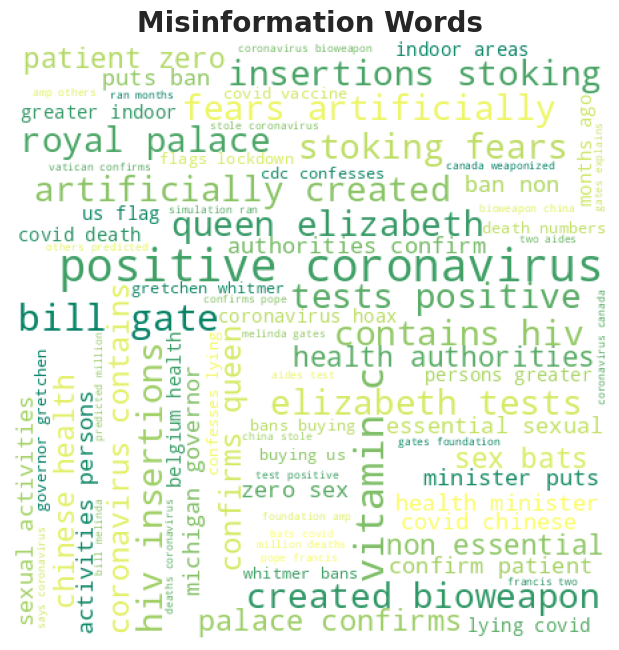

In [27]:
text = ' '.join(list(fakenewsdf['processed_tweet'])) # get list of all words in the fakenewsdf dataset

wordcloud = WordCloud(width=450, height=450, background_color='white', min_font_size=8, colormap='summer').generate(text) # create wordcloud using words from tweets labeled as 'fake news'

plt.figure(figsize=(6,6), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Misinformation Words', size='20', fontweight='bold')

plt.show()

### Sentiment Analysis

**Textblob** sentiment analyzer returns two properties for a given input sentence:


*   Polarity is a float that lies between [-1,1], -1 indicates negative sentiment and +1 indicates positive sentiments.

*   Subjectivity is also a float which lies in the range of [0,1]. Subjective sentences generally refer to personal opinion, emotion, or judgment.

Textblob uses a lexicon-based approach to determine the sentiment of text.

**Source:** https://textblob.readthedocs.io/en/dev/




In [28]:
from textblob import TextBlob

print("Running Sentiment Analysis")

# for loop to get sentiment of text. can be built as function as well.
for row in tweetdf.itertuples():
    tweet = tweetdf.at[row[0], "processed_tweet"]

    analysis = TextBlob(tweet) # applies the TextBlob function to each tweet in the dataset

    tweetdf.at[row[0], "Polarity"] = analysis.sentiment[0] # gets the 'Polarity' score from the TextBlob function output
    tweetdf.at[row[0], "Subjectivity"] = analysis.sentiment[1] # gets the 'Subjectivity' score from the TextBlob function output

    # the following uses the 'Polarity' score to identify if the tweet is 'Positive', 'Negative' or 'Neutral' and assigns that classification to the tweet
    if analysis.sentiment[0] > 0:
        tweetdf.at[row[0], "Sentiment"] = "Positive"
    elif analysis.sentiment[0] < 0:
        tweetdf.at[row[0], "Sentiment"] = "Negative"
    else:
        tweetdf.at[row[0], "Sentiment"] = "Neutral"

Running Sentiment Analysis


In [29]:
tweetdf = tweetdf[['tweet', 'cleaned_tweet', 'processed_tweet', 'Polarity', 'Subjectivity', 'Sentiment', 'tweet_class']] # this is used to arrange the columns as wanted
tweetdf.head()

,tweet,cleaned_tweet,processed_tweet,Polarity,Subjectivity,Sentiment,tweet_class
0,"Ian Haydon, who is participating in a vaccine ...",ian haydon participating vaccine trial coronav...,ian haydon participating vaccine trial coronav...,0.075000,0.325000,Positive,misinformation
1,Gachibowli Sports Tower turns Covid hospital\n...,gachibowli sports tower turns covid hospital s...,gachibowli sports tower turns covid hospital s...,-0.050000,0.050000,Negative,misinformation
2,"Protesters at state Capitol are chanting ""Wher...",protesters state capitol chanting flag pointin...,protesters state capitol chanting flag pointin...,0.000000,0.000000,Neutral,misinformation
4,1/2\n\n@WHO recently published a summary of tr...,recently published summary transmission incl s...,recently published summary transmission incl s...,0.000000,0.250000,Neutral,misinformation
5,2/2 ... on transmission from asymptomatic indi...,transmission asymptomatic individuals difficul...,transmission asymptomatic individuals difficul...,-0.066667,0.616667,Negative,misinformation


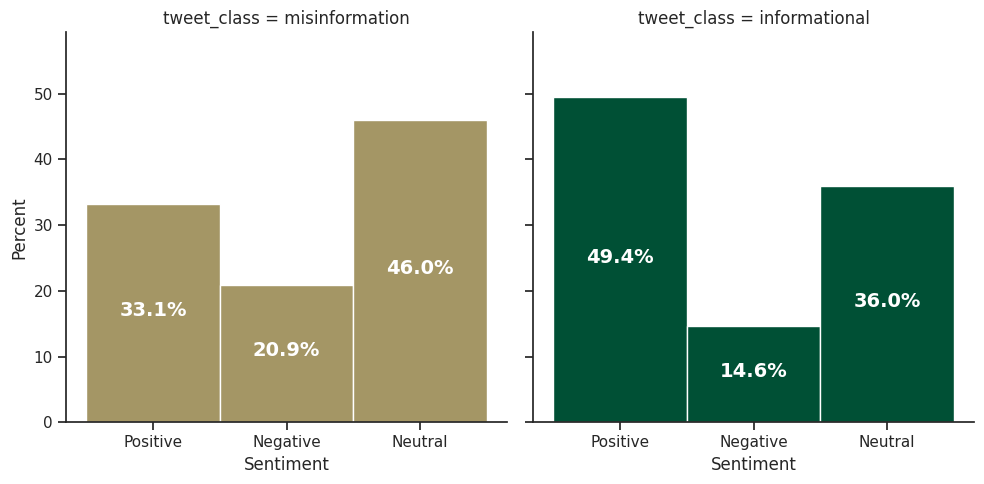

In [30]:
p1 = sns.displot(tweetdf, x="Sentiment", col="tweet_class", col_wrap=2, stat='percent', hue="tweet_class", legend=False, common_norm=False, palette=pal, alpha=1)

for ax in p1.axes.ravel():

    # add percentage labels to displots
    for c in ax.containers:

        labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]

        ax.bar_label(c, labels=labels, label_type='center', fontsize=14, padding=2, color='white', weight='bold') # add labels to plot and format those labels

    ax.margins(y=0.2) # set the axis margins

plt.tight_layout()
plt.show()

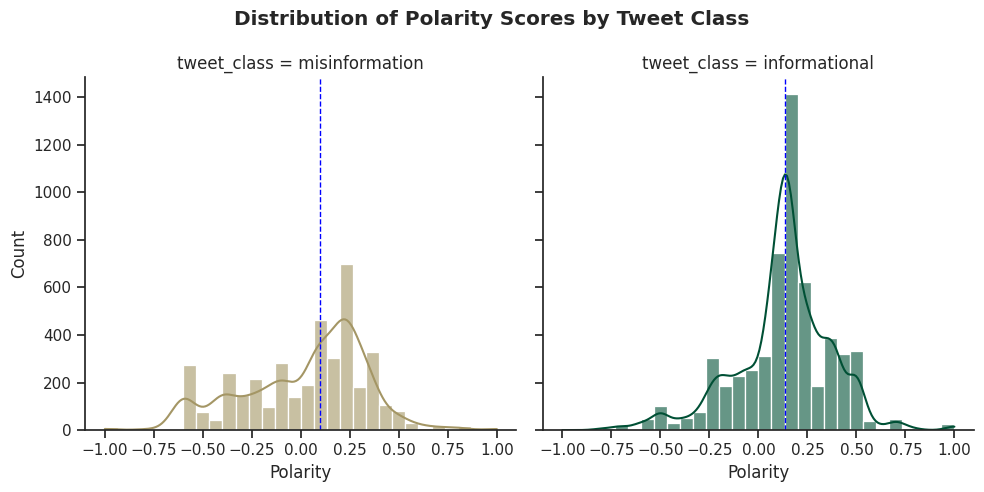

In [31]:
# create distribution plot of 'Polarity' scores by 'tweet_class'
p3 = sns.displot(data=tweetdf[~(tweetdf['Polarity'] == 0)],
        x='Polarity',
        col='tweet_class',
        col_wrap=2,
        hue='tweet_class',
        legend=False,
        palette=pal,
        kde=True,
        bins=30,
        alpha=0.6)

# add title to the plot
p3.fig.suptitle("Distribution of Polarity Scores by Tweet Class", fontweight='bold')

# add line on axis of each plot to show the median 'Polarity' score for each class
for (row, col, hue_idx), data in p3.facet_data():
    if not data.values.size:
        continue
    ax = p3.facet_axis(row, col)
    ax.axvline(data['Polarity'].median(), c="blue", ls="--", lw=1.0)

plt.tight_layout()
plt.show()

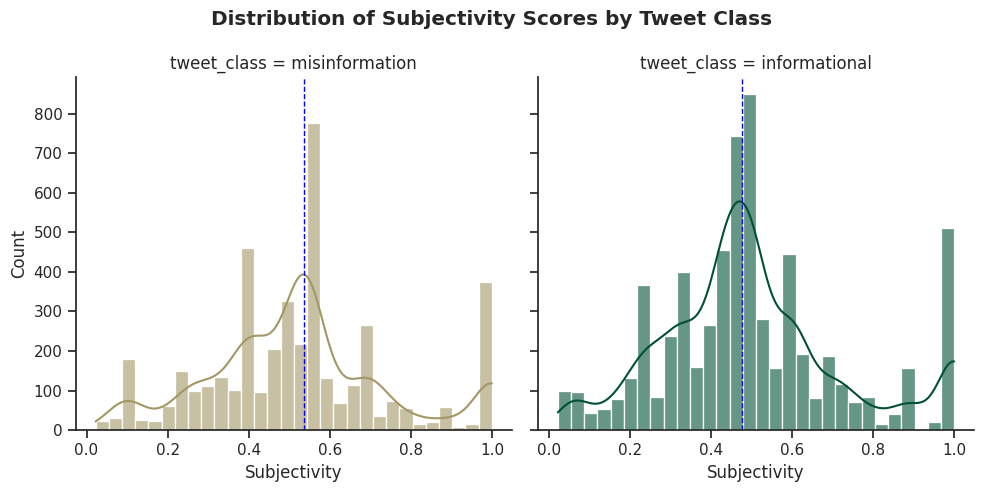

In [32]:
# create distribution plot of 'Subjectivity' scores by 'tweet_class'
p2 = sns.displot(data=tweetdf[~(tweetdf['Subjectivity'] == 0)],
        x='Subjectivity',
        col='tweet_class',
        col_wrap=2,
        hue='tweet_class',
        legend=False,
        palette=pal,
        kde=True,
        bins=30,
        alpha=0.6)

# add title to the plot
p2.fig.suptitle("Distribution of Subjectivity Scores by Tweet Class", fontweight='bold')

# add line on axis of each plot to show the median 'Subjectivity' score for each class
for (row, col, hue_idx), data in p2.facet_data():
    if not data.values.size:
        continue
    ax = p2.facet_axis(row, col)
    ax.axvline(data['Subjectivity'].median(), c="blue", ls="--", lw=1.0)

plt.tight_layout()
plt.show()

### Part-of-Speech Tagging

In [33]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

# define function to identify the parts of speech for each word within each tweet
def pos_func(text):
    word_list = nltk.word_tokenize(text)
    pos_tagged = nltk.pos_tag(word_list)
    print(pos_tagged)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [34]:
# perform POS tagging on one tweet from the dataset
pos_output = pos_func(tweetdf['processed_tweet'][30])
pos_output

[('spain', 'NN'), ('doctor', 'NN'), ('brought', 'VBD'), ('guitar', 'NN'), ('hospital', 'NN'), ('thinking', 'VBG'), ('would', 'MD'), ('sing', 'VB'), ('raise', 'VB'), ('everyone', 'NN'), ('spirits', 'NNS'), ('something', 'NN'), ('unexpected', 'JJ'), ('happened', 'VBD'), ('everyone', 'NN'), ('started', 'VBD'), ('singing', 'VBG'), ('chills', 'NNS')]


The following is an overview of all the available part-of-speech tags.

In [35]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### Topic Modeling

In [36]:
# import gensim for topic modeling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases

# define function to preprocess text
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence)))

all_words = list(sent_to_words(data['processed_tweet']))
fake_words = list(sent_to_words(fakenewsdf['processed_tweet']))
true_words = list(sent_to_words(truenewsdf['processed_tweet']))

print(all_words[:1])

[['trump', 'also', 'cut', 'funding', 'cdc', 'forcing', 'cdc', 'cancel', 'efforts', 'help', 'countries', 'prevent', 'infectious', 'disease', 'threats', 'becoming', 'epidemics', 'countries', 'among', 'countries', 'abandoned', 'china']]


In [45]:
# set input text
text = fake_words

# generate bigrams
bigram = Phrases(text, min_count=1, threshold=1)  # You can adjust the parameters based on your needs.
bigram_mod = gensim.models.phrases.Phraser(bigram)
bigram_text = [bigram_mod[doc] for doc in text]

In [46]:
# set input text
input_text = bigram_text

# Create Dictionary
id2word = corpora.Dictionary(input_text)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in input_text]

In [47]:
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                            num_topics=10,
                                            id2word=id2word,
                                            passes=15)

In [48]:
# View the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.056*"hiv_insertions" + 0.055*"coronavirus_contains" + 0.055*"artificially_created" + 0.055*"stoking_fears" + 0.035*"hedge" + 0.035*"bioweapon_zero" + 0.034*"coronavirus" + 0.024*"bioweapon" + 0.022*"deaths_coronavirus" + 0.021*"behind_fingerprint"
Topic: 1 
Words: 0.041*"bill_gates" + 0.039*"permanently_alter" + 0.038*"vaccine_use" + 0.038*"experimental_technology" + 0.038*"explains_covid" + 0.037*"dna" + 0.024*"months_ago" + 0.022*"gates_foundation" + 0.021*"bill_melinda" + 0.021*"predicted_million"
Topic: 2 
Words: 0.027*"bats" + 0.026*"confirm_patient" + 0.026*"zero_sex" + 0.026*"covid_chinese" + 0.014*"flu_vaccine" + 0.014*"military_study" + 0.013*"increases_coronavirus" + 0.013*"risk_says" + 0.010*"donald_trump" + 0.008*"street_main"
Topic: 3 
Words: 0.032*"areas" + 0.031*"ban_non" + 0.031*"greater_indoor" + 0.031*"activities_persons" + 0.031*"minister_puts" + 0.031*"belgium_health" + 0.031*"essential_sexual" + 0.019*"wall_street" + 0.018*"main_street" + 0.018*"

## **Additional Resource for R Users**

The following is a great resource for R users to learn "Text Mining with R":

https://www.tidytextmining.com/index.html

## **Exploring the Use of Zero-Shot Classification for Text Annotation**

Zero-shot text classification is a task in natural language processing where a model is trained on a set of labeled examples but is then able to classify new examples from previously unseen classes.

Source: https://huggingface.co/tasks/zero-shot-classification

In [49]:
!pip install transformers

# transformers package supported by Hugging Face (https://huggingface.co/docs/transformers/index)
from transformers import pipeline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.9 MB/s eta 0:00:00


In [51]:
# use pipeline to download zero-shot classifier model from Hugging Face
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [58]:
# set candidate labels
intent_labels = ["question information",
                 "provide information",
                 "suggest a political motive",
                 "promote alternative",
                 "promote prevention",
                 "provide support"]

# set hypothesis template for the zero-shot model
hypothesis_template = "The intent of this tweet is to {}."

# example of tweet to use with the classifier
text = "The NY Times exposes real reason behind coronavirus hype: Crash the market to harm Trump's reelection chances"

# "The NY Times exposes real reason behind coronavirus hype: Crash the market to harm Trump's reelection chances"

# "COVID-19 vaccine candidate shows promise in first peer-reviewed research"

# classifier that predicts which candidate label should be applied to the input text
result = classifier(text, intent_labels, hypothesis_template=hypothesis_template, multi_label=True)
print(f"Input: {text}")
print(f"Labels: {result['labels']}\nScores: {result['scores']}")

Input: The NY Times exposes real reason behind coronavirus hype: Crash the market to harm Trump's reelection chances
Labels: ['suggest a political motive', 'provide information', 'question information', 'promote alternative', 'promote prevention', 'provide support']
Scores: [0.9970935583114624, 0.9675841927528381, 0.9379172325134277, 0.03487778827548027, 0.01034717820584774, 0.0008001375827006996]
